Comparação dos modelos treinados ao decorrer do projeto

Necessário carregar a database original para fazer a parte da validação



In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import kagglehub
import os
import pathlib
from sklearn.model_selection import train_test_split


path = kagglehub.dataset_download("rakibuleceruet/drowsiness-prediction-dataset")
data_dir = pathlib.Path(os.path.join(path, '0 FaceImages'))

active_paths = list(data_dir.glob('Active Subjects/*.jpg'))
active_labels = [0] * len(active_paths)
fatigue_paths = list(data_dir.glob('Fatigue Subjects/*.jpg'))
fatigue_labels = [1] * len(fatigue_paths)
all_image_paths = [str(p) for p in (active_paths + fatigue_paths)]
all_labels = active_labels + fatigue_labels

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))


IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image, label


validation_dataset = (
    val_ds
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [10]:
MODELS_DIR = "saved_models"
HISTORIES_DIR = "historicos"

model_tl_path = os.path.join(MODELS_DIR, 'modelo_transfer_learning.keras')
modelo_tl = tf.keras.models.load_model(model_tl_path)

model_seq_path = os.path.join(MODELS_DIR, 'modelo_sequencialv2.keras') #usando o modelo com as camadas de dropout e global average pooling
modelo_sequential = tf.keras.models.load_model(model_seq_path)

print("\n--- Avaliação Final do Modelo Sequencial ---")
val_loss_seq, val_acc_seq = modelo_sequential.evaluate(validation_dataset, verbose=1)
print(f"Acurácia do Modelo Sequencial: {val_acc_seq * 100:.2f}%")


print("\n--- Avaliação Final do Modelo de Transfer Learning ---")
val_loss_tl, val_acc_tl = modelo_tl.evaluate(validation_dataset, verbose=1)
print(f"Acurácia do Modelo de Transfer Learning: {val_acc_tl * 100:.2f}%")


--- Avaliação Final do Modelo Sequencial ---
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8141 - loss: 0.3913
Acurácia do Modelo Sequencial: 81.41%

--- Avaliação Final do Modelo de Transfer Learning ---
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 0.8377 - loss: 0.3502
Acurácia do Modelo de Transfer Learning: 83.77%


In [11]:
history_tl_path = os.path.join(HISTORIES_DIR, 'history_transfer_learning.pkl')
history_seq_path = os.path.join(HISTORIES_DIR, 'history_sequencial.pkl')

with open(history_tl_path, 'rb') as file:
    historia_tl = pickle.load(file)

with open(history_seq_path, 'rb') as file:
    historia_sequencial = pickle.load(file)


--- Relatório Detalhado do Modelo Sequencial ---
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
                   precision    recall  f1-score   support

Alerta (Classe 0)       0.83      0.79      0.81       912
Fadiga (Classe 1)       0.80      0.84      0.82       912

         accuracy                           0.81      1824
        macro avg       0.81      0.81      0.81      1824
     weighted avg       0.81      0.81      0.81      1824


--- Matriz de Confusão do Modelo Sequencial ---


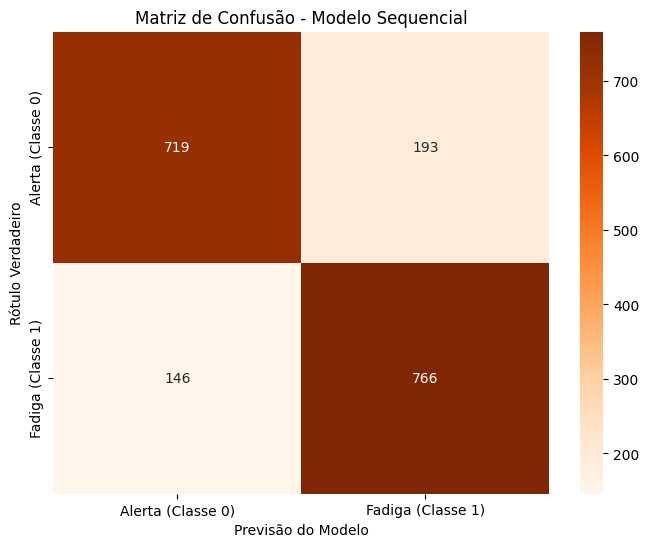


--- Relatório Detalhado do Modelo de Transfer Learning ---
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step
                   precision    recall  f1-score   support

Alerta (Classe 0)       0.82      0.86      0.84       912
Fadiga (Classe 1)       0.85      0.82      0.83       912

         accuracy                           0.84      1824
        macro avg       0.84      0.84      0.84      1824
     weighted avg       0.84      0.84      0.84      1824


--- Matriz de Confusão do Modelo de Transfer Learning ---


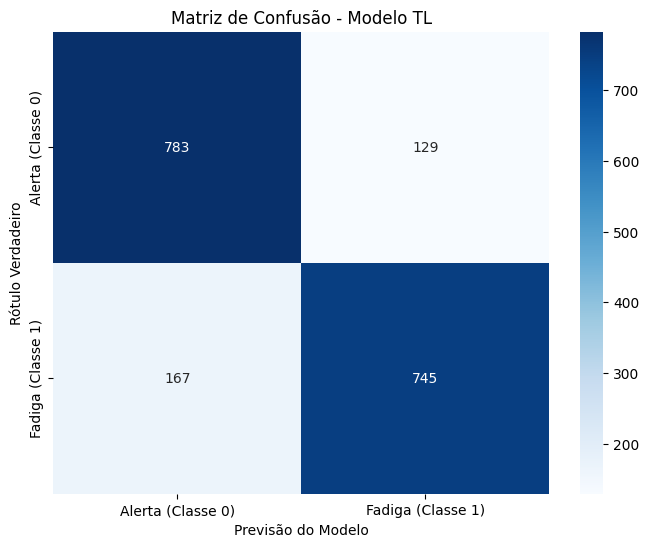

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

print("\n--- Relatório Detalhado do Modelo Sequencial ---")

y_true = np.concatenate([y for x, y in validation_dataset], axis=0)

y_pred_probs_seq = modelo_sequential.predict(validation_dataset)
y_pred_seq = (y_pred_probs_seq > 0.5).astype(int).flatten()
target_names = ['Alerta (Classe 0)', 'Fadiga (Classe 1)']
print(classification_report(y_true, y_pred_seq, target_names=target_names))

print("\n--- Matriz de Confusão do Modelo Sequencial ---")
cm_seq = confusion_matrix(y_true, y_pred_seq)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_seq, annot=True, fmt='d', cmap='Oranges', xticklabels=target_names, yticklabels=target_names) # Mudei a cor para diferenciar
plt.xlabel('Previsão do Modelo')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão - Modelo Sequencial')
plt.show()



print("\n--- Relatório Detalhado do Modelo de Transfer Learning ---")
y_pred_probs_tl = modelo_tl.predict(validation_dataset)
y_pred_tl = (y_pred_probs_tl > 0.5).astype(int).flatten()
print(classification_report(y_true, y_pred_tl, target_names=target_names))

print("\n--- Matriz de Confusão do Modelo de Transfer Learning ---")
cm_tl = confusion_matrix(y_true, y_pred_tl)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Previsão do Modelo')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão - Modelo TL')
plt.show()

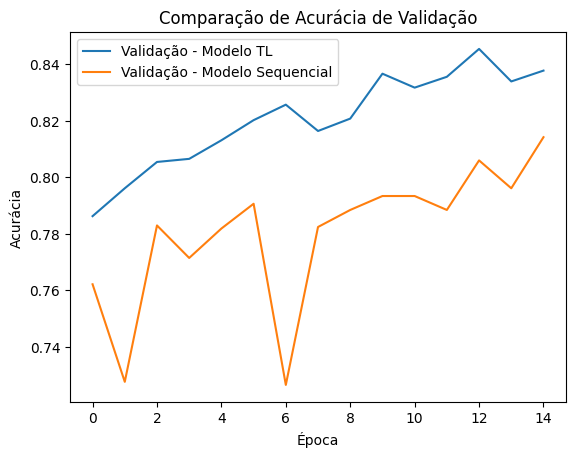

In [13]:
plt.plot(historia_tl['val_accuracy'], label='Validação - Modelo TL')
plt.plot(historia_sequencial['val_accuracy'], label='Validação - Modelo Sequencial')
plt.title("Comparação de Acurácia de Validação")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

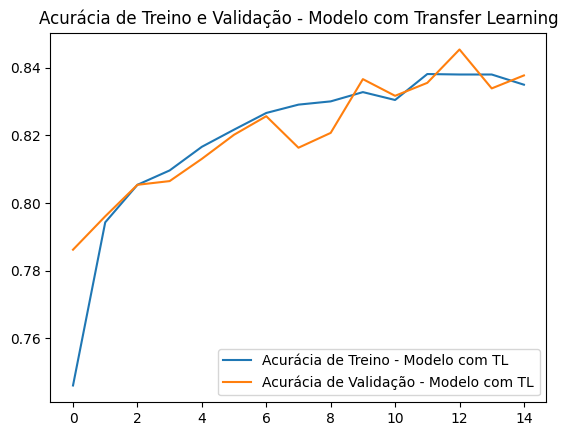

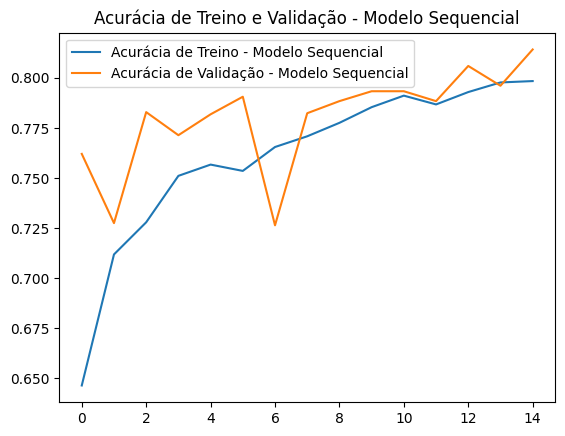

In [14]:
plt.title("Acurácia de Treino e Validação - Modelo com Transfer Learning"  )
plt.plot(historia_tl['accuracy'], label='Acurácia de Treino - Modelo com TL')
plt.plot(historia_tl['val_accuracy'], label='Acurácia de Validação - Modelo com TL')
plt.legend()
plt.show()

plt.title("Acurácia de Treino e Validação - Modelo Sequencial"  )   
plt.plot(historia_sequencial['accuracy'], label='Acurácia de Treino - Modelo Sequencial')
plt.plot(historia_sequencial['val_accuracy'], label='Acurácia de Validação - Modelo Sequencial')
plt.legend()
plt.show()
#!/usr/bin/env python3